### Prepare spatial training data

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import imageio
import xarray
import scipy
import inspect
import sys
import cellpose
from cellpose import models

In [474]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install inspect-it

In [27]:
def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)
    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )
    if clip:
        x = np.clip(x,0,1)
    return x

def normalize_img(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """Percentile-based image normalization."""
    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)

### Load spatial data

Load gene dots, image and cell segmentation

In [2]:
gene_count = pd.read_csv("../data/xenium/xenium_0002328_Ctl_2_A/0002328_Ctl_2_A_transcripts.csv")
gene_count.head(3)

,target,y_location,x_location
0,Lyz2,56563.035294,11637.112941
1,Dkk3,56515.383529,11639.507294
2,Dkk3,55097.581176,11641.424471


In [3]:
dapi = tifffile.imread("../data/xenium/xenium_0002328_Ctl_2_A/0002328_Ctl_2_A_dapi_mip.ome.tif") # crop1 dapi

In [37]:
x_sub_min = 32000 ; x_sub_max = 38000
y_sub_min = 17000 ; y_sub_max = 22000
dapi_ = dapi[x_sub_min:x_sub_max,y_sub_min:y_sub_max].copy()

In [38]:
dapi_n = normalize_img(dapi_)

In [39]:
sel_dots = gene_count.y_location.between(y_sub_min, y_sub_max) & gene_count.x_location.between(x_sub_min, x_sub_max)
gene_count_ = gene_count.iloc[np.array(sel_dots)]

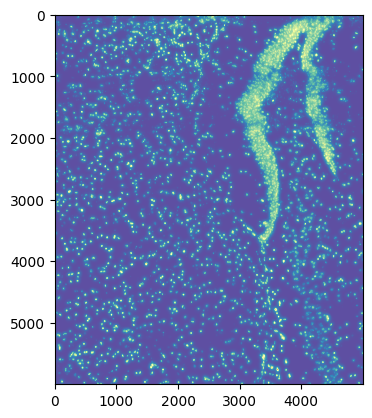

In [40]:
plt.imshow(dapi_n, cmap='Spectral_r')

In [36]:
cellpose_nuclei = models.CellposeModel(model_type='nuclei')

In [41]:
cellpose_nuclei(dapi_)

TypeError: 'CellposeModel' object is not callable

In [4]:
#seg_cell = imageio.v2.imread('../data/crop1_dapi_cp_masks.png')
seg_bin = seg_cell.copy() # We build also a binary mask
seg_bin[seg_bin > 0] = 1

In [5]:
q1perc = np.quantile(np.unique(seg_cell, return_counts=True)[1][1:], q=[0.01,0.99])[0]

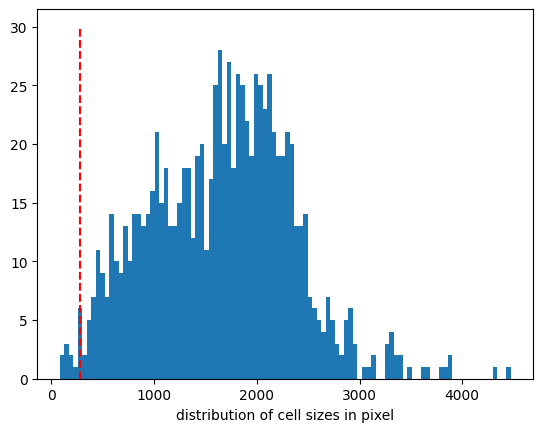

In [6]:
plt.hist(np.unique(seg_cell, return_counts=True)[1][1:], bins=100)
plt.vlines(x=q1perc, ymin=0, ymax=30, color='r', linestyles='dashed')
plt.xlabel('distribution of cell sizes in pixel')
plt.show()

### Find Cell centroids

In [7]:
# Build variable with unique Cell IDs
cell_ids = pd.Series(np.unique(seg_cell)[1:])

def get_cell_centroids(seg, cell_ids):
# Function to find cell centroids based on cell segmentation
    coords = []
    for i in cell_ids:
        coords.append([np.mean(x) for x in np.where(seg == i)])
    return pd.DataFrame(coords, columns = ['y', 'x'], index=cell_ids)[['x', 'y']]

In [8]:
cell_loc = get_cell_centroids(seg_cell, cell_ids)
cell_loc.head(3)

,x,y
1,315.172769,10.245995
2,603.687129,11.507921
3,228.066025,17.689592


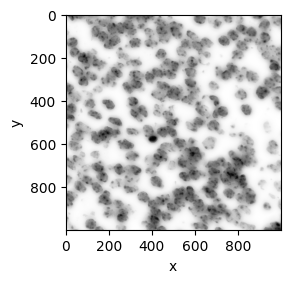

In [9]:
plt.figure(figsize=(3,3))
plt.imshow(dapi[500:1500,500:1500], cmap='Greys', alpha=1.0)
plt.xlabel('x') ; plt.ylabel('y')
plt.tight_layout()
#plt.savefig("../results/figs/crop1_img_500-1500.pdf", dpi=300)
plt.show()

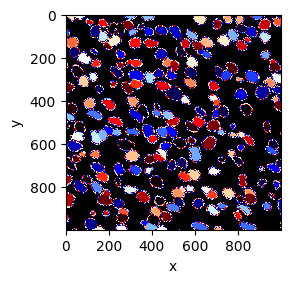

In [12]:
plt.figure(figsize=(3,3))
plt.imshow(seg_cell[500:1500,500:1500], cmap='flag_r', alpha=1.0)
plt.xlabel('x') ; plt.ylabel('y')
plt.tight_layout()
#plt.savefig("../results/figs/crop1_seg_500-1500.pdf", dpi=300)
plt.show()

In [13]:
choose_dots = np.array(np.array(cell_loc['x'] > 500) & np.array(cell_loc['x'] < 1500) & np.array(cell_loc['y'] > 500) & np.array(cell_loc['y'] < 1500))
cell_loc_sub = cell_loc.iloc[choose_dots].copy()
cell_loc_sub['x'] = cell_loc_sub['x'] - 500
cell_loc_sub['y'] = cell_loc_sub['y'] - 500

In [14]:
choose_dots = np.array(np.array(gene_count['x'] > 500) & np.array(gene_count['x'] < 1500) & np.array(gene_count['y'] > 500) & np.array(gene_count['y'] < 1500))
gene_count_sub = gene_count.iloc[choose_dots].copy()
gene_count_sub['x'] = gene_count_sub['x'] - 500
gene_count_sub['y'] = gene_count_sub['y'] - 500

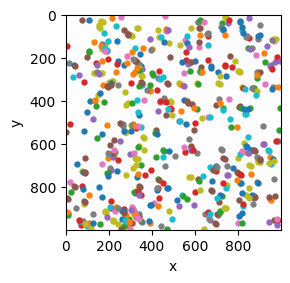

In [15]:
plt.figure(figsize=(3,3))
plt.imshow(dapi[500:1500,500:1500], cmap='copper', alpha=0.01)
for gene in np.unique(gene_count_sub.name):
    gene_count_sub_sub = gene_count_sub.iloc[np.array(gene_count_sub.name == gene)]
    plt.scatter(gene_count_sub_sub.x, gene_count_sub_sub.y, marker='.', s=50.0)
plt.xlabel('x') ; plt.ylabel('y')
plt.tight_layout()
#plt.savefig("../results/figs/crop1_img_500-1500_geneDots.pdf", dpi=300)
plt.show()

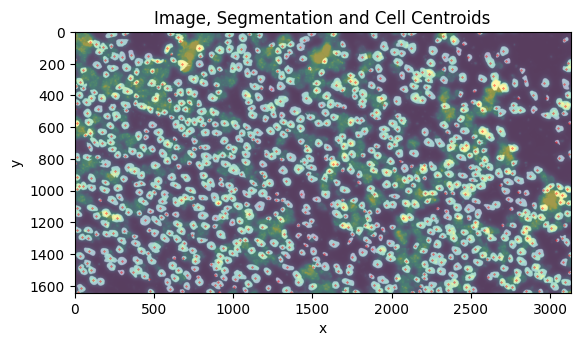

In [16]:
plt.imshow(seg_bin, cmap = 'gray', alpha=0.6) ; plt.imshow(dapi, cmap='viridis', alpha=0.4)
plt.scatter(cell_loc.x, cell_loc.y, color='r', s=0.1) ; plt.title('Image, Segmentation and Cell Centroids')
plt.xlabel('x') ; plt.ylabel('y')
#plt.savefig("../results/figs/crop1_seg_centroids.pdf", dpi=300)
plt.show()

### Attribute RNA transcript to cells

Based on segmentation, we can attribute high condifence counts to the closest cell to build our input matrix $\mathbf{X}$. Let's first visualize an overlay of segmentaiton, cell centroids and detected RNA transcripts: 

In [17]:
cell_loc_sub

,x,y
234,298.669407,0.554738
235,374.792547,4.783851
243,62.302937,6.376352
245,23.206986,14.078913
246,618.379736,22.302256
...,...,...
812,362.616000,965.873600
815,839.268325,983.098623
818,619.032575,982.829094
819,391.729651,987.245930


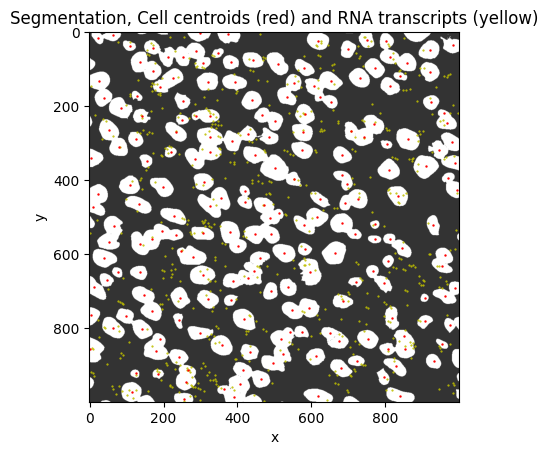

In [105]:
plt.imshow(seg_bin[500:1500,500:1500], cmap = 'gray', alpha=0.8)
plt.scatter(gene_count_sub.x, gene_count_sub.y, color='y', s=0.3) ; 
plt.scatter(cell_loc_sub.x, cell_loc_sub.y, color='r', s=0.5)
plt.title('Segmentation, Cell centroids (red) and RNA transcripts (yellow)')
plt.xlabel('x') ; plt.ylabel('y')
#plt.savefig("../results/figs/crop1_seg_centroids_counts.pdf", dpi=300)
plt.show()

In [120]:
# Fix Gene count to fit segmentation size: remove one extra line in gene_count data :
gene_count = gene_count.iloc[np.array(gene_count.y != 1645)].copy()
gene_count.index = range(gene_count.shape[0]) # reindex

In [121]:
def get_closest_cell(seg, cell_x, cell_y, max_shift=30):
# Based on segmentation and x,y coordinates of a cell, the closest cell is returned
# If no cell is found in a distance of `max_shift` around the gene dot, 0 will be
# returns meaning no cell attributed
    for i in range(1,max_shift):
        shift=i
        cell_ids = np.unique(seg_cell.T[x-shift:x+shift+1,y-shift:y+shift+1])
        cell_ids = cell_ids[cell_ids!=0] # remove 'cell number 0' corredponding to background
        if any(cell_ids != 0): # test if a cell is detected
            n_cells_detected = len(cell_ids)
            if n_cells_detected == 1: # test if only one cell is detected
                return cell_ids[0]
            else: # if more than one cell is detected, return nothing
                return 0 # 'cell number 0' means no cell was detected 
    return 0

Now that we define a function to find the closest cell based on $\{x,y\}$ coordinates, we iterate over all detected RNA transcript and attribute a cell ID when a cell is found is the neighborhood without ambiguity. 

In [122]:
closest_cells = []
for c in range(gene_count.shape[0]):
    x = gene_count.loc[c].x
    y = gene_count.loc[c].y
    closest_cells.append(get_closest_cell(seg_cell, x, y, max_shift=30))

In [123]:
closest_cells[0:5]

[0, 899, 909, 908, 907]

In [208]:
# If the code above is run another time, drop the columns: 
#gene_count.drop(['cell'], inplace=True, axis=1)
#gene_count.drop(['attributed'], inplace=True, axis=1)

In [124]:
gene_count.insert(3, 'cell', value=np.array(closest_cells, dtype=int))
attributed = gene_count['cell'].copy()
attributed[attributed > 0] = 1
gene_count.insert(4, 'attributed', value=np.array(attributed))
gene_count_attributed = gene_count.iloc[np.array(gene_count['attributed'] == 1)].copy()

In [125]:
np.array(gene_count_attributed['x'] > 500) & np.array(gene_count_attributed['x'] < 1500)

array([ True, False,  True, ..., False, False, False])

In [126]:
gene_count_attributed_sub = gene_count_attributed.iloc[np.array(gene_count_attributed['x'] > 500) & np.array(gene_count_attributed['x'] < 1500) & np.array(gene_count_attributed['y'] > 500) & np.array(gene_count_attributed['y'] < 1500)]

In [108]:
gene_count_attributed_sub.loc[:,'x'] = gene_count_attributed_sub.loc[:,'x'] - 500 
gene_count_attributed_sub.loc[:,'y'] = gene_count_attributed_sub.loc[:,'y'] - 500 

/Users/acoudray/Desktop/tmp_samba/phd/gioele_project/2212_spatial-sc/spatial-sc/spatial-sc-env/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Let's have a look at RNA transcript that were attributed to a cell (blue) versus RNA transcript with no attribution (yellow). 

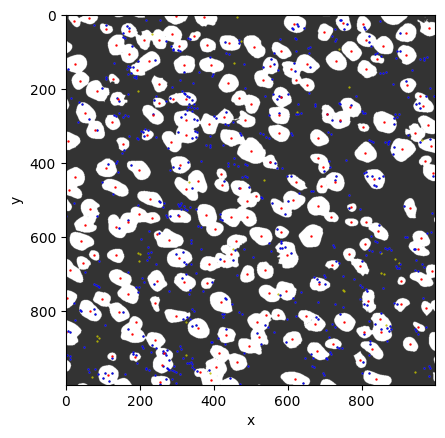

In [109]:
plt.imshow(seg_bin[500:1500,500:1500], cmap = 'gray', alpha=0.8)
plt.scatter(gene_count_sub.x, gene_count_sub.y, color='y', s=0.3)
plt.scatter(gene_count_attributed_sub.x, gene_count_attributed_sub.y, color='b', s=0.5)
plt.scatter(cell_loc_sub.x, cell_loc_sub.y, color='r', s=0.5)
#plt.title('Cell centroids, cellpose segmentation, and gene counts')
plt.xlabel('x') ; plt.ylabel('y')
plt.savefig("../results/figs/crop1_seg_centroids_counts_attributed.pdf", dpi=300)
plt.show()

## Look at local neighborhood of a single-cell

In [246]:
window_radius = 256
x_ = int(1002-window_radius/2) ; y_ = int(740-window_radius/2)
low_bound_x = x_ - window_radius ; low_bound_y = y_ - window_radius
high_bound_x= x_ + window_radius ; high_bound_y= y_ + window_radius

cell_loc_sub_s = cell_loc.iloc[np.array(cell_loc.x > low_bound_x) & np.array(cell_loc.x < high_bound_x) & 
                              np.array(cell_loc.y > low_bound_y) & np.array(cell_loc.y < high_bound_y)]
cell_loc_sub_s.x = cell_loc_sub_s.x - x_ + window_radius
cell_loc_sub_s.y = cell_loc_sub_s.y - y_ + window_radius

In [247]:
choose_dots = np.array(np.array(gene_count['x'] > low_bound_x) & np.array(gene_count['x'] < high_bound_x) & 
                       np.array(gene_count['y'] > low_bound_y) & np.array(gene_count['y'] < high_bound_y))
gene_count_sub = gene_count.iloc[choose_dots].copy()
gene_count_sub['x'] = gene_count_sub['x'] - x_ + window_radius
gene_count_sub['y'] = gene_count_sub['y'] - y_ + window_radius

In [248]:
gene_count_attributed_sub = gene_count_attributed.iloc[np.array(gene_count_attributed['x'] > low_bound_x) & 
                                                       np.array(gene_count_attributed['x'] < high_bound_x) & 
                                                       np.array(gene_count_attributed['y'] > low_bound_y) & 
                                                       np.array(gene_count_attributed['y'] < high_bound_y)].copy()
gene_count_attributed_sub['x'] = gene_count_attributed_sub['x'] - x_ + window_radius
gene_count_attributed_sub['y'] = gene_count_attributed_sub['y'] - y_ + window_radius

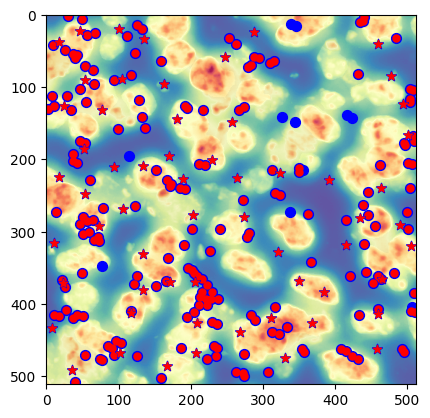

In [249]:
plt.imshow(seg_bin[x_-window_radius:x_+window_radius, y_-window_radius:y_+window_radius], cmap = 'Blues_r', alpha=0.5)
plt.imshow(dapi[x_-window_radius:x_+window_radius, y_-window_radius:y_+window_radius], cmap = 'Spectral_r', alpha=0.9)
plt.scatter(gene_count_sub.x, gene_count_sub.y, color='b', s=50)
plt.scatter(gene_count_attributed_sub.x, gene_count_attributed_sub.y, color='r', s=25)
plt.scatter(cell_loc_sub_s.x, cell_loc_sub_s.y, color='b', s=55, marker='*')
plt.scatter(cell_loc_sub_s.x, cell_loc_sub_s.y, color='r', s=35, marker='*')

In [213]:
from matplotlib.collections import LineCollection
def get_all_edges(bool_img):
    """
    Get a list of all edges (where the value changes from True to False) in the 2D boolean image.
    The returned array edges has he dimension (n, 2, 2).
    Edge i connects the pixels edges[i, 0, :] and edges[i, 1, :].
    Note that the indices of a pixel also denote the coordinates of its lower left corner.
    """
    edges = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            edges.append(np.array([[i, j+1],
                                   [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            edges.append(np.array([[i+1, j],
                                   [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            edges.append(np.array([[i, j],
                                   [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            edges.append(np.array([[i, j],
                                   [i, j+1]]))

    if not edges:
        return np.zeros((0, 2, 2))
    else:
        return np.array(edges)


def close_loop_edges(edges):
    """
    Combine thee edges defined by 'get_all_edges' to closed loops around objects.
    If there are multiple disconnected objects a list of closed loops is returned.
    Note that it's expected that all the edges are part of exactly one loop (but not necessarily the same one).
    """
    loop_list = []
    while edges.size != 0:

        loop = [edges[0, 0], edges[0, 1]]  # Start with first edge
        edges = np.delete(edges, 0, axis=0)

        while edges.size != 0:
            # Get next edge (=edge with common node)
            ij = np.nonzero((edges == loop[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                loop.append(loop[0])
                # Uncomment to to make the start of the loop invisible when plotting
                # loop.append(loop[1])
                break

            loop.append(edges[i, (j + 1) % 2, :])
            edges = np.delete(edges, i, axis=0)

        loop_list.append(np.array(loop))
    return loop_list

def plot_outlines(bool_img, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    edges = get_all_edges(bool_img=bool_img)
    edges = edges - 0.5  # convert indices to coordinates; TODO adjust according to image extent
    outlines = close_loop_edges(edges=edges)
    cl = LineCollection(outlines, **kwargs)
    ax.add_collection(cl)

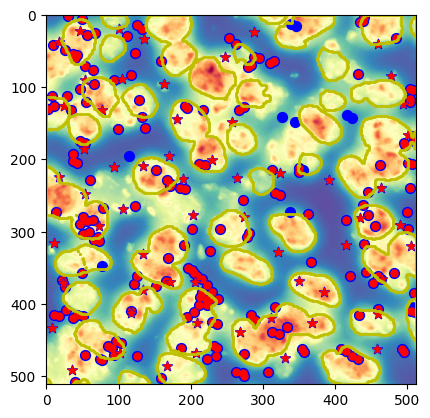

In [252]:
#plt.imshow(seg_bin[x_-window_radius:x_+window_radius, y_-window_radius:y_+window_radius], cmap = 'Blues_r', alpha=0.5)
ax = plt.gca()
plt.imshow(dapi[x_-window_radius:x_+window_radius, y_-window_radius:y_+window_radius], cmap = 'Spectral_r', alpha=1)
plot_outlines(seg_bin[x_-window_radius:x_+window_radius, y_-window_radius:y_+window_radius].T, lw=2, color='y', ax=ax)
plt.scatter(gene_count_sub.x, gene_count_sub.y, color='b', s=50)
plt.scatter(gene_count_attributed_sub.x, gene_count_attributed_sub.y, color='r', s=25)
plt.scatter(cell_loc_sub_s.x, cell_loc_sub_s.y, color='b', s=55, marker='*')
plt.scatter(cell_loc_sub_s.x, cell_loc_sub_s.y, color='r', s=35, marker='*')
plt.show()

### Build spatial expression matrix X

Based on attributed dot-to-cell gene counts, we can now build $\mathbf{X}$, the spatial gene expression matrix containing gene counts attributed to cells with high confidence.  

In [529]:
gene_count.pivot_table(index='cell', columns='name', values='attributed', 
                                      aggfunc= 'sum').fillna(0).astype(int)

name,Agt,Aldoc,Ano1,Aqp4,Atoh1,Barhl1,Barhl2,Bmp4,C1qa,Car4,...,Tlx3,Tmem119,Tmem212,Tnc,Vax2,Vit,Wfdc1,Wnt5b,Wnt7b,Zic4
cell,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [260]:
X = gene_count_attributed.pivot_table(index='cell', columns='name', values='attributed', 
                                      aggfunc= 'sum').fillna(0).astype(int)
# verify that all gene counts where attributed (should be equal to gene_count_attributed.shape[0])
np.sum(np.array(X).flatten()) ==  gene_count_attributed.shape[0]

True

In [290]:
# How many cells are found in X ? Let's check the proportion of cells that got at least 1 count...
print(str(round(100*X.shape[0]/len(np.unique(seg_cell)))) + '% of cells got at least 1 RNA count')

82% of cells got at least 1 RNA count


In [291]:
X.head()

name,Agt,Aldoc,Ano1,Aqp4,Atoh1,Barhl1,Barhl2,Bmp4,C1qa,Car4,...,Tlx3,Tmem119,Tmem212,Tnc,Vax2,Vit,Wfdc1,Wnt5b,Wnt7b,Zic4
cell,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
4**20

1099511627776

In [5]:
3e9/1048576

2861.02294921875

In [337]:
# We get missing cell IDs
missing_ids = cell_ids[~cell_ids.isin(X.index)]
missing_ids = missing_ids.astype(str)
# We build an empty data.frame with missing cell IDs
pd_missing_data = pd.DataFrame(np.zeros((len(missing_ids), X.shape[1])), index=missing_ids, columns=X.columns)
# We build X_supp which contains cell with 0 counts 
X_supp = pd.concat([X, pd_missing_data]).astype(int)
X_supp.index = X_supp.index.astype(int)
X_supp = X_supp.sort_index()
X_supp.head()

name,Agt,Aldoc,Ano1,Aqp4,Atoh1,Barhl1,Barhl2,Bmp4,C1qa,Car4,...,Tlx3,Tmem119,Tmem212,Tnc,Vax2,Vit,Wfdc1,Wnt5b,Wnt7b,Zic4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's have a look at how many counts are detected per cell:

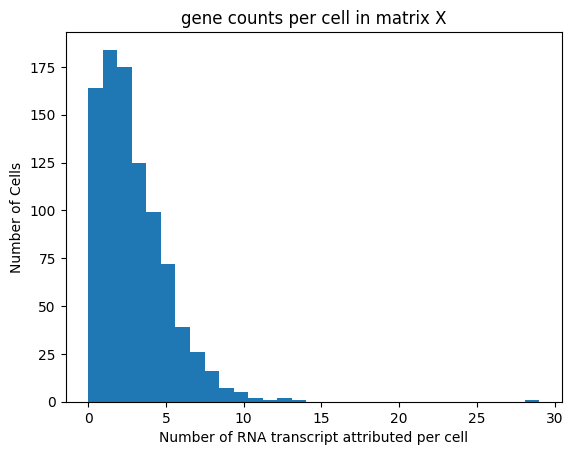

In [338]:
plt.hist(X_supp.sum(axis=1), bins=31)
plt.xlabel('Number of RNA transcript attributed per cell') ; plt.ylabel("Number of Cells")
plt.title("gene counts per cell in matrix X")
plt.show()

### Prepare A matrix the whole image

Matrix $\mathbf{A}$ are centered on the cell of interest, and is of size $(E\times E \times G)$, with $E$ being the width of the window and $G$ the number of genes in our data. This matrix will then be passed in a Convolutional Neural Network to be summarized in a smaller set of features, used to infer cell-type identity probabilities.

We will use cell centroids to center our window and construct our matrices A:

In [372]:
gene_count.insert(5, 'value', 1)

In [384]:
full_A = gene_count.pivot_table(index='y', columns='x', values='value', 
                                aggfunc= 'sum').fillna(0).astype(int)
full_A = full_A.reindex(range(seg_cell.shape[0]), axis=0, fill_value=0)
full_A = full_A.reindex(range(seg_cell.shape[1]), axis=1, fill_value=0)

In [390]:
# get unique gene names 
gene_names = np.unique(gene_count.name)

In [417]:
all_As = []
for gene in gene_names:
    gene_count_1gene = gene_count.iloc[np.array(gene_count.name == gene)]
    A_1gene = gene_count_1gene.pivot_table(index='y', columns='x', values='value', 
                                aggfunc= 'sum').fillna(0).astype(int)
    A_1gene = A_1gene.reindex(range(seg_cell.shape[0]), axis=0, fill_value=0)
    A_1gene = A_1gene.reindex(range(seg_cell.shape[1]), axis=1, fill_value=0)
    all_As.append(np.array(A_1gene))

In [419]:
full_A = np.array(all_As)
A_xr = xarray.DataArray(full_A, [ ("genes", gene_names), ("x", range(seg_cell.shape[0])), ("y", range(seg_cell.shape[1]))] )

In [441]:
A_xr.to_netcdf("../data/crop1_A_mat.nc")

Extract $\mathbf{A}_c$ for a single-cell c

In [442]:
# Let's use cell number 100 as an example (not in the boarder)
cell_idx = 100
x = cell_loc.iloc[cell_idx].x
y = cell_loc.iloc[cell_idx].y

In [443]:
window_size = 201 ; shift = (window_size - 1)/2
x_coord_start = int(x - shift) ; x_coord_end = int(x + shift)
y_coord_start = int(y - shift) ; y_coord_end = int(y + shift)
print(np.array([x_coord_start, x_coord_end, y_coord_start, y_coord_end]))

[2089 2289  150  350]


In [450]:
# We can derive dapi and/or mask centered on the cell:
dapi_c = dapi[y_coord_start:y_coord_end,x_coord_start:x_coord_end]
mask_c = seg_bin[y_coord_start:y_coord_end,x_coord_start:x_coord_end]

In [448]:
# Then we can get A_c 
A_c = A_xr[:,y_coord_start:y_coord_end,x_coord_start:x_coord_end]

In [125]:
def logger(comment):
    """Function to print Class::Name - Comments from any classes

    Args:
        comment (str): comment to add to the logger
    """
    class_fun_str = inspect.stack()[1][0].f_locals["self"].__class__.__name__ + "::" + \
                    inspect.stack()[1].function + "()"
    print("{:<40} - {:<50}".format(class_fun_str, comment))

def drawProgressBar(percent, barLen = 100):
    # percent float from 0 to 1. 
    sys.stdout.write("\r")
    sys.stdout.write("[{:<{}}] {:.0f}%".format("=" * int(barLen * percent), barLen, percent * 100))
    sys.stdout.flush()
        
class Cell(object):
    def __init__(self, x, loc, label, e=None, A=None, seg=None, img=None, pi=None, z=None):
        """This class contain a Cell and all data related to a single-cell c
        
        Args:
            x (np.array, 1D): the spatial gene expression, from dots confidently attributed to cell c
            A (xarray, 3D): 3D spatial expression containing coordinate of gene counts in local neighborhood
            loc (np.array, 1D): contain x,y location of cell c centroid
            seg (np.array, 2D): segmentation centered on cell c containing neighbor cells in local neighborhood
            img (np.array, 2D): image centered on cell c containing neighbor cells in local neighborhood
            label (int): label of cell c
            e (int): size of local neighborhood window, centroids will be enlarged by +/- e 
            pi (torch 1D tensor): probability to be affiliated to each K cell type
            z (torch 1D tensor): assignment of cell type based on pi_c
        """
        self.x = x
        self.A = A
        self.loc = loc
        self.label = label
        self.seg = seg
        self.img = img
        self.pi = pi
        self.z = z
        self.x_start = None ; self.x_end = None
        self.y_start = None ; self.y_end = None
        self.on_boarder = False
        
    def build_crops_c(self, A, seg, img, e, x_width, y_width):
        """ Crop full size image, segmentation and matrix A, centered on cell c
            Cell centroids will be enlarged by +/- e"""
        #logger(f'cropping image, mask, segmentation and matrix A for cell {self.label}')
        # record coordinates of local neighborhood
        self.x_start = int(self.loc.x - e) ; self.x_end = int(self.loc.x + e + 1)
        self.y_start = int(self.loc.y - e) ; self.y_end = int(self.loc.y + e + 1)
        # crop input matrices 
        self.A = A[:,self.x_start:self.x_end,self.y_start:self.y_end] # size (G, 2e, 2e), G number of genes
        self.seg = seg[self.x_start:self.x_end,self.y_start:self.y_end]
        #self.mask_c = mask[self.y_start:self.y_end,self.x_start:self.x_end]
        self.img = img[self.x_start:self.x_end,self.y_start:self.y_end]
        if self.x_start < 0 or self.y_start < 0 or self.x_end > x_width or self.y_end > y_width:
            self.on_boarder = True
        
class CellContainer(object):
    def __init__(self, img, seg, D, e, M=None, A=None, X=None, loc=None, cell_labels=None, gene_names=None, 
                 celltype_labels=None, ignore_cells_with_0transript = True):
        """CellContainer class contains all segmented cells form an image, and their associated spatial gene expression
        
        Args:
            img (np.array, 2D): dapi staining raw image, size (width_X, width_Y)
            seg (np.array, 2D): nuclei segmentation based on dapi staining
            D (pd.DataFrame, 3 columns): Gene dots information, columns are (gene_name, x_coord, y_coord).
            e (int): size of enlargement around cell centroids for making crops used by CNN.
            A (xarray, 3D): contains the dot corresponding the spatial gene counts.xarray of size (G, width_X, width_Y), G being the number of genes, and (width_X,width_Y) the size of the full image. Calculated on the fly from D.
            X (np.array, 2D): contains the gene counts confidently assigned to each cell c segmented in the spatial data. Calculated on the fly from seg, C, and D.
            loc (pandas, 3 columns): cell centroid information, columns are (cell_label, x_coord, y_coord)
            M (pd.DataFrame): scRNA-seq data with average gene expression per cell types size (K, G), K being the number of cell-types and G the number of genes
            cell_labels (pd.Series, 1D): labels of cells in X, based on labels in segmentation matrix. Calculated on the fly from seg.
            gene_names (pd.Series, 1D): labels of genes in matrix A, X, and M. Calculated on the fly from unique gene names in D.
            celltype_labels (pd.Series, 1D): labels of cell-types in M. 
            ignore_cells_with_0transript (bool): [default: True] defines if cells that get 0 RNA transcript should be ignored
        """
        self.img = img
        self.seg = seg
        self.D = D
        self.e = e
        self.A = A 
        self.X = X
        self.loc = None
        self.M = M
        self.cell_labels = pd.Series(np.unique(self.seg)[1:]) # Build variable with unique Cell IDs
        self.gene_names = pd.Series(np.unique(self.D.name))
        self.celltype_labels = None
        self.ignore_cells_with_0transript = ignore_cells_with_0transript
        self.X_miss = None # matrix X including cells with 0 transcripts
        self.cell_labels_miss = None # cell labels including cells with 0 transcripts
        self.cells = [] # list containing all Cell in image
        self.x_width = self.seg.shape[0]
        self.y_width = self.seg.shape[1]

    def get_cell_centroids(self):
        """Function to find cell centroids based on cell segmentation"""
        logger(f'Computing cell centroids based on segmentation file')
        coords = []
        for i in self.cell_labels:
            coords.append([np.mean(x) for x in np.where(seg == i)])
        self.loc = pd.DataFrame(coords, columns = ['x', 'y'], index=self.cell_labels)
        
    def find_closest_cell(self, x, y, max_shift=30):
        """Given (cell_x, cell_y) cell centroid coordinates, returns the closest cell in a radius of max_shift"""
        for i in range(1,max_shift):
            shift=i
            cell_ids = np.unique(self.seg[x-shift:x+shift+1,y-shift:y+shift+1])
            cell_ids = cell_ids[cell_ids!=0] # remove 'cell number 0' corredponding to background
            if any(cell_ids != 0): # test if a cell is detected
                n_cells_detected = len(cell_ids)
                if n_cells_detected == 1: # test if only one cell is detected
                    return cell_ids[0]
                else: # if more than one cell is detected, return nothing
                    return 0 # 'cell number 0' means no cell was detected 
        return 0
    
    def build_X_matrix(self, max_shift=30):
        """Based on segmentation and x,y coordinates of a cell, the closest cell is returned
            If no cell is found in a distance of max_shift around the gene dot, 0 will be
            returns meaning no cell attributed"""
        logger(f'Attributing gene dots to closest cells')
        closest_cells = []
        for c in range(self.D.shape[0]):
            x = self.D.loc[c].x
            y = self.D.loc[c].y
            closest_cells.append(self.find_closest_cell(x, y, max_shift=max_shift))
        # Add info in dataframe D
        self.D.insert(3, 'cell', value=np.array(closest_cells, dtype=int))
        attributed = self.D['cell'].copy()
        attributed[attributed > 0] = 1
        self.D.insert(4, 'attributed', value=np.array(attributed)) 
        
        logger("""Build matrix X based on dot attribution""")
        self.X = self.D.pivot_table(index='cell', columns='name', values='attributed', 
                                    aggfunc= 'sum').fillna(0).astype(int)
        self.X = self.X[1:]
        logger(str(round(100*self.X.shape[0]/len(np.unique(self.seg)))) + '% of cells got at least 1 RNA count') 
        if self.ignore_cells_with_0transript:
            logger("""Ignoring segmented cells with 0 RNA transcript. Updating cell_labels""")
            self.cell_labels = self.X.index
        else:
            self.add_missing_cells_in_X()
            
    def add_missing_cells_in_X(self):
        """Adds rows for cells that got 0 RNA transcript attributed"""
        # We get missing cell IDs
        missing_ids = self.cell_labels[~self.cell_labels.isin(self.X.index)].astype(str)
        # We build an empty data.frame with missing cell IDs
        pd_missing_data = pd.DataFrame(np.zeros((len(missing_ids), self.X.shape[1])), index=missing_ids, columns=self.X.columns)
        # We build X_supp which contains cell with 0 counts 
        self.X_miss = pd.concat([self.X, pd_missing_data]).astype(int)
        self.X_miss.index = self.X_miss.index.astype(int)
        self.X_miss = self.X_miss.sort_index()

    def subset_cells(self, cell_ids):
        """Subsetting cells in all tables to fit cell labels in self.cell_labels variable"""
        logger("""Subsetting cells in self.X, self.X, and self.X""")
        
    def build_A_matrix(self):
        """Build matrix A based on gene dots in D"""
        logger("Build matrix A based on gene dots in D")
        self.D.insert(5, 'value', 1)
        all_As = []
        for gene in self.gene_names:
            gene_count_1gene = self.D.iloc[np.array(self.D.name == gene)]
            A_1gene = gene_count_1gene.pivot_table(index='x', columns='y', values='value', 
                                                   aggfunc= 'sum').fillna(0).astype(int)
            A_1gene = A_1gene.reindex(range(self.seg.shape[0]), axis=0, fill_value=0)
            A_1gene = A_1gene.reindex(range(self.seg.shape[1]), axis=1, fill_value=0)
            all_As.append(np.array(A_1gene))
        self.A = xarray.DataArray(np.array(all_As), [ ("genes", self.gene_names), ("x", range(self.seg.shape[0])), ("y", range(self.seg.shape[1]))] )
    
    def build_Cell_objects(self):
        """Build Cell objects based on cell_labels, X, seg, and cell centroids, used as training data for our model."""
        logger("Build Cell objects based on X, A, seg, and cell centroids")
        logger("Iterating over cells:")
        n_cells = len(self.cell_labels)
        for cn, c in enumerate(self.cell_labels):
            Cell_obj = Cell(x=np.array(self.X.loc[c]), loc=self.loc.loc[c], label=c)
            Cell_obj.build_crops_c(A=self.A, seg=self.seg, img=self.img, e=self.e, 
                                   x_width=self.x_width, y_width=self.y_width)
            self.cells.append(Cell_obj)
            progress = (cn + 1) / n_cells
            drawProgressBar(progress, barLen=100)

In [98]:
D = pd.read_csv("../data/crop1_genes.csv")
img = tifffile.imread("../data/crop1_dapi.tif").T
seg = imageio.v2.imread('../data/crop1_dapi_cp_masks.png').T

In [99]:
# fix mistake in input D
D = D.iloc[np.array(D.y != 1645)].copy()
D.index = range(D.shape[0]) # reindex

In [126]:
e = 50 # size of the crops: cell centroids are enlarged by +/- e pixels
CellContainer_obj = CellContainer(img=img.copy(), seg=seg.copy(), D=D.copy(), e=e)
CellContainer_obj.build_X_matrix()
CellContainer_obj.get_cell_centroids()
CellContainer_obj.build_A_matrix()
CellContainer_obj.build_Cell_objects()

CellContainer::build_X_matrix()          - Attributing gene dots to closest cells            
CellContainer::build_X_matrix()          - Build matrix X based on dot attribution           
CellContainer::build_X_matrix()          - 82% of cells got at least 1 RNA count             
CellContainer::build_X_matrix()          - Ignoring segmented cells with 0 RNA transcript. Updating cell_labels
CellContainer::get_cell_centroids()      - Computing cell centroids based on segmentation file
CellContainer::build_A_matrix()          - Build matrix A based on gene dots in D            
CellContainer::build_Cell_objects()      - Build Cell objects based on X, A, seg, and cell centroids
CellContainer::build_Cell_objects()      - Iterating over cells:                             
[====================================================================================================] 100%